In [1]:
catName = 'low'

In [2]:
import sys, os, pickle, time, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from array import array

import ROOT as rt
rt.TGaxis.SetMaxDigits(4)
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH1D, create_TH2D, SetMaxToMaxHist
from gridVarQ2Plot import col_dic, label_dic
from progressBar import ProgressBar
from categoriesDef import categories
cat = categories[catName]

from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = 7*' ' + 'Internal'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [4]:
m_mu = 0.1056583755
m_Dst = 2.01026
m_B0 = 5.2796

In [5]:
catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

In [6]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [7]:
dfSig = pd.DataFrame(rtnp.root2array('../data/cmsRD/skimmed/B2DstMu_200515_{}_skip16_corr.root'.format(cat.name)))
dfWrong = pd.DataFrame(rtnp.root2array('../data/cmsRD/skimmed/B2DstMu_combDstmMum_200611_{}_skip16_corr.root'.format(cat.name)))

In [8]:
dataDir = '../data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2DstMu_200515*')
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part2_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part1_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part4_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part3_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu7_IP4_part0_v2 1.27
Total lumi: 6.39 fb^-1


In [9]:
' '.join(np.sort(dfSig.columns))

'B_eta B_phi B_pt D0_eta D0_phi D0_pt Dst_eta Dst_phi Dst_pt Est_mu K_eta K_phi K_pt M2_miss N_goodAddTks N_vtx U_miss cat_high cat_low cat_mid cosT_D0pismu_PV cos_D0pismu_PV index localVertexDensity mass_D0pis mass_D0pismu mass_piK muPass_Mu12_IP6 muPass_Mu7_IP4 muPass_Mu9_IP6 mu_eta mu_phi mu_pt mu_sigdxy pi_eta pi_phi pi_pt pis_eta pis_phi pis_pt pval_D0pis pval_D0pismu pval_piK q2 sigdxy_vtxD0_PV tkCharge_0 tkCharge_1 tkEta_0 tkEta_1 tkMassHad12 tkMassHad_0 tkMassHad_1 tkMassMiss2_0 tkMassMiss2_1 tkMassMuTk_0 tkMassMuTk_1 tkMassVis12 tkMassVis_0 tkMassVis_1 tkPhi_0 tkPhi_1 tkPtError_0 tkPtError_1 tkPt_0 tkPt_1 tkUmiss12 tkUmiss_0 tkUmiss_1'

## Remove splitted tracks from wring sign sample

In [10]:
def computeDeltaR(dset, sp1='pi', sp2='K'):
    deta = dset[sp1+'_eta'] - dset[sp2+'_eta']
    dphi = dset[sp1+'_phi'] - dset[sp2+'_phi']
    dphi = np.where(np.abs(dphi) > np.pi, dphi - np.sign(dphi)*2*np.pi, dphi)
    return np.hypot(deta, dphi)

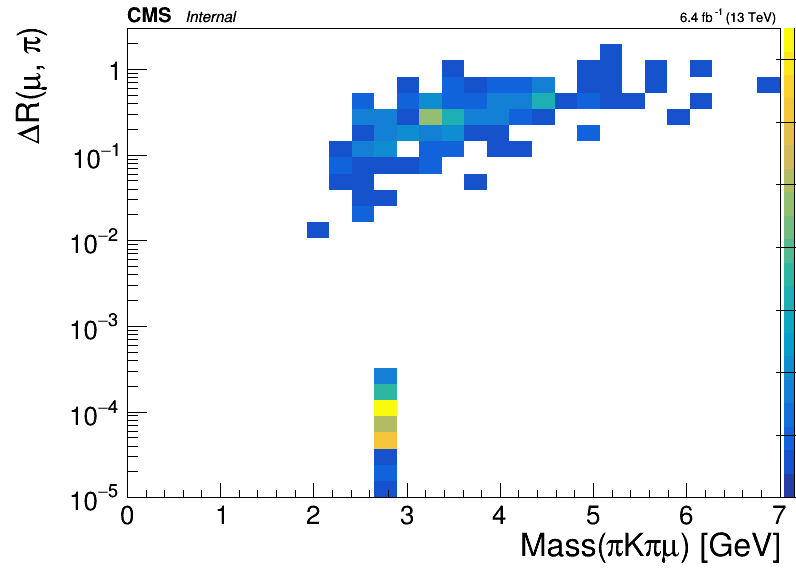

In [13]:
dfWrong['dR_pimu'] = computeDeltaR(dfWrong, sp1='pi', sp2='mu')

h2 = create_TH2D(dfWrong[['mass_D0pismu', 'dR_pimu']], binning=[np.linspace(0,7, 30), np.logspace(-5,np.log10(3), 30)],
                 axis_title=['Mass(#piK#pi#mu) [GeV]', '#DeltaR(#mu, #pi)', '']
                )
c = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'])
c.SetLogy()

selWrong = dfWrong['dR_pimu'] > 1e-3

# Visible system mass

In [14]:
Nsig = np.sum(dfSig['mass_D0pismu'] > m_B0+0.1)
Nwrong = np.sum(dfWrong['mass_D0pismu'][selWrong] > m_B0+0.1)
print Nsig, Nwrong

r = Nsig/float(Nwrong)
dr = r*np.hypot(1./Nsig, 1./Nwrong)
print 'Ratio: {:.2f} +/- {:.2f} ({:.0f} %)'.format(r, dr, 100*dr/r)

3 9
Ratio: 0.33 +/- 0.12 (35 %)


<ROOT.TLine object ("TLine") at 0xad42ab0>

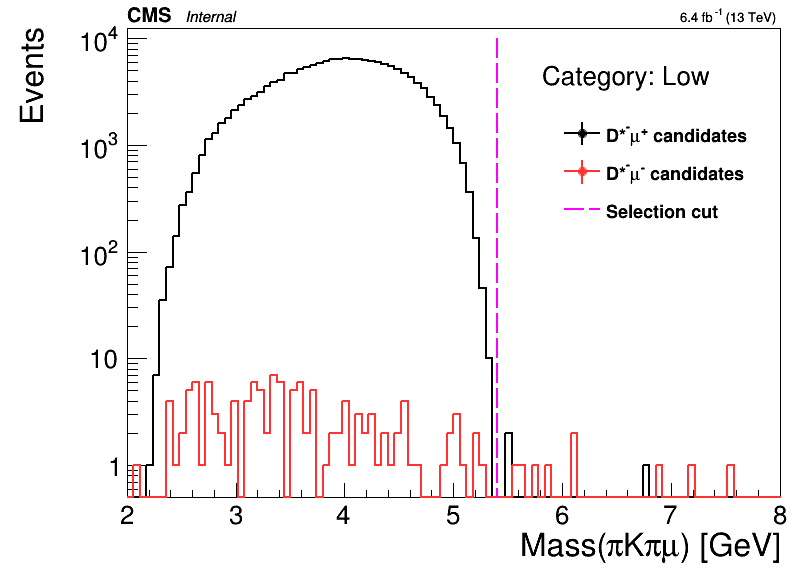

In [15]:
h1 = create_TH1D(dfSig['mass_D0pismu'], 
                 binning=[100, 2, 8],
                 opt='overflow',
                 axis_title=['Mass(#piK#pi#mu) [GeV]', 'Events'],
                )
h1.SetMarkerStyle(8)
h2 = create_TH1D(dfWrong['mass_D0pismu'][selWrong], binning=h1.binning,
                 opt='overflow',
                 color=1
                )
h2.SetMarkerStyle(8)

leg = rt.TLegend(0.7, 0.6, 0.95, 0.8)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(h1, 'D*^{-}#mu^{+} candidates', 'lep')
leg.AddEntry(h2, 'D*^{-}#mu^{-} candidates', 'lep')
leg.AddEntry(cl, 'Selection cut', 'l')
    
c = drawOnCMSCanvas(CMS_lumi, [h1, h2], 'same')
c.SetLogy()
catText.DrawLatexNDC(0.9, 0.85, 'Category: {}'.format(cat.name))
leg.Draw()
cl.DrawLine(5.4, 0.5, 5.4, 1e4)

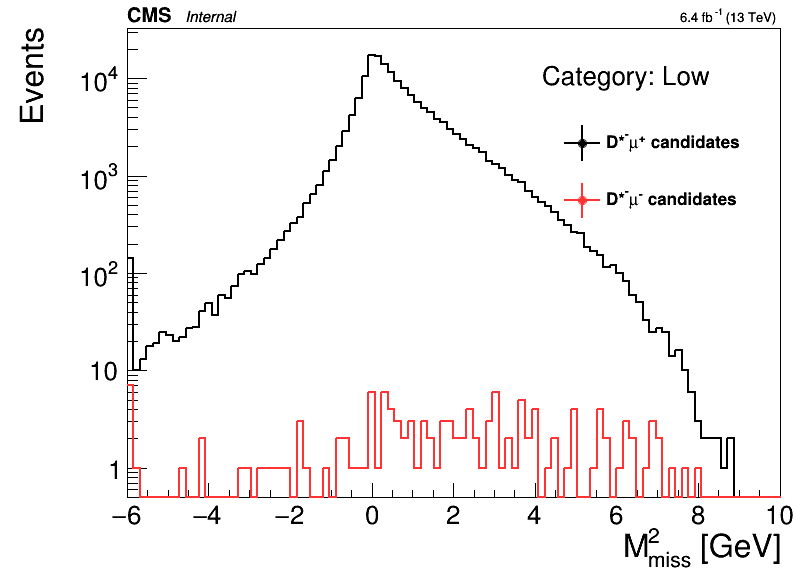

In [16]:
h1 = create_TH1D(dfSig['M2_miss'], 
                 binning=[100, -6, 10],
                 opt='overflow+underflow',
                 axis_title=['M^{2}_{miss} [GeV]', 'Events'],
                )
h1.SetMarkerStyle(8)
h2 = create_TH1D(dfWrong['M2_miss'][selWrong], binning=h1.binning,
                 opt='overflow+underflow',
                 color=1
                )
h2.SetMarkerStyle(8)

leg = rt.TLegend(0.7, 0.6, 0.95, 0.8)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(h1, 'D*^{-}#mu^{+} candidates', 'lep')
leg.AddEntry(h2, 'D*^{-}#mu^{-} candidates', 'lep')
    
c = drawOnCMSCanvas(CMS_lumi, [h1, h2], 'same')
c.SetLogy()
catText.DrawLatexNDC(0.9, 0.85, 'Category: {}'.format(cat.name))
leg.Draw()